In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split


Populating the interactive namespace from numpy and matplotlib



# About this project  (Sathvik Thandra Neural Networks Writing Sample)

# Image classification on CIFAR-10


### Preliminaries information:
In this problem we will explore different deep learning architectures for image classification on the CIFAR-10
dataset. If you are not comfortable with PyTorch from the previous lecture and discussion materials, use the tutorials at http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html and make sure you
are familiar with tensors, two-dimensional convolutions (`nn.Conv2d`) and fully-connected layers (`nn.Linear`),
ReLU non-linearities (`F.relu`), pooling (`nn.MaxPool2d`), and tensor reshaping (`view`).



- Each network $f$ maps an image $x^{\rm in} \in \mb{R}^{32 \times 32 \times 3}$ (3 channels for RGB) to an output $f(x^{\rm in}) = x^{\rm out} \in \mb{R}^{10}$. The class label is predicted as $\arg\max_{i=0,1,\dots,9} x_{i}^{\rm out}$.

- The network is trained via multiclass cross-entropy loss (log of softmax function).  Specifically, for an input image and label pair $(x^{\rm in} , c)$ where $c\in \{0,\dots, 9\}$. If the network’s
output layer is $x^{\rm out} \in \mb{R}^{10}$, the loss $-\log\left(\frac{\exp(x_c^{\rm out})}{\sum_{c'} \exp(x_{c'}^{\rm out})}\right)$.

- For computational efficiency reasons, this particular network considers mini-batches of images per training
step meaning the network actually maps $B=4$ images per feed-forward so that $\tilde{x}^{\rm in}\in\mb{R}^{B\times 32 \times 32 \times 3}$ and $\tilde{x}^{\rm out}\in\mb{R}^{B\times 10}$.  This is ignored in the network descriptions below but it is something to be aware of.

- we will Create a validation dataset by appropriately partitioning the train dataset.

- The cross-entropy loss for a neural network is, in general, non-convex. This means that the optimization
method may converge to different local minima based on different hyperparameters of the optimization
procedure (e.g., stepsize). Usually one can find a good setting for these hyperparameters by just observing
the relative progress of training over the first epoch or two (how fast is it decreasing) but you are warned
that early progress is not necessarily indicative of the final convergence value (you may converge quickly to a poor local minimum whereas a different step size could have poor early performance but converge to
a better final value).

- While one would usually train a network for hundreds of epochs to reach convergence and maximize accuracy, this can be prohibitively time-consuming, so feel free to train for just a a dozen or so epochs.


Here we,

- Report the hyperparameter configurations you evaluated and the best set of hyperparameters
from this set.  

- Plot the training and validation classification accuracy as a function of iteration. Produce
a separate line or plot for each hyperparameter configuration evaluated (please try to use multiple lines in a single plot to keep the number of figures minimal).

- Finally, evaluate your best set of
hyperparameters on the test data and report the accuracy.



The number of hyperparameters to tune, combined with the slow training times, will hopefully give
you a taste of how difficult it is to construct networks with good generalization performance. It should be emphasized that the
networks we constructed are **tiny**.
State-of-the-art networks can have dozens of layers, each with their own hyperparameters to tune. Additional
hyperparameters you are welcome to play with if you are so inclined, include: changing the activation
function, replace max-pool with average-pool, adding more convolutional or fully connected layers, and
experimenting with batch normalization or dropout.


---







In [ ]:

sns.set()
torch.manual_seed(592)
np.random.seed(592)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [ ]:
def prepare_dataset(batch_size=64, train_val_split_ratio=0.9):

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    cifar10_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(cifar10_set) * train_val_split_ratio)
    val_size   = len(cifar10_set) - train_size

    cifar10_trainset, cifar10_valset = torch.utils.data.random_split(cifar10_set, [train_size, val_size])
    cifar10_testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(cifar10_valset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(cifar10_testset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader


In [ ]:
train_loader, val_loader, test_loader = prepare_dataset(batch_size=64, train_val_split_ratio=0.9)

Files already downloaded and verified


In [ ]:
print("Training DataLoader:")
print("Number of batches:", len(train_loader))
for batch_idx, (data, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print("Data shape:", data.shape)
    print("Targets shape:", targets.shape)
    break

Training DataLoader:
Number of batches: 704
Batch 1:
Data shape: torch.Size([64, 3, 32, 32])
Targets shape: torch.Size([64])


In [ ]:
print("\nValidation DataLoader:")
print("Number of batches:", len(val_loader))
for batch_idx, (data, targets) in enumerate(val_loader):
    print(f"Batch {batch_idx + 1}:")
    print("Data shape:", data.shape)
    print("Targets shape:", targets.shape)
    break


Validation DataLoader:
Number of batches: 79
Batch 1:
Data shape: torch.Size([64, 3, 32, 32])
Targets shape: torch.Size([64])


In [ ]:
# Printing information about the test loader
print("\nTest DataLoader:")
print("Number of batches:", len(test_loader))
for batch_idx, (data, targets) in enumerate(test_loader):
    print(f"Batch {batch_idx + 1}:")
    print("Data shape:", data.shape)
    print("Targets shape:", targets.shape)
    break


Test DataLoader:
Number of batches: 157
Batch 1:
Data shape: torch.Size([64, 3, 32, 32])
Targets shape: torch.Size([64])


In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, batch_size):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Update statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += targets.size(0)
            correct_train += predicted.eq(targets).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()

                _, predicted = outputs.max(1)
                total_val += targets.size(0)
                correct_val += predicted.eq(targets).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val

        # Record statistics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies



In [ ]:
def evaluation(model, test_loader, criterion):

    model.eval()  # Setting the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            _, predicted = outputs.max(1)
            total_test += targets.size(0)
            correct_test += predicted.eq(targets).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct_test / total_test

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    return test_loss, test_accuracy


##  Fully-connected output, no hidden layers (logistic regression)
We begin with the simplest network
possible that has no hidden layers and simply linearly maps the input layer to the output layer. That is,
conceptually it could be written as
\begin{align*}
    x^{\rm out} &= W \text{vec}(x^{\rm in}) +b
\end{align*}
where $x^{\rm out} \in \mb{R}^{10}$, $x^{\rm in} \in \mb{R}^{32 \times 32 \times 3}$, $W \in \mb{R}^{10 \times 3072}$, $b \in \mb{R}^{10}$ since $3072 = 32 \cdot 32 \cdot 3$. For a tensor $x \in \mb{R}^{a \times b \times c}$, we let $\text{vec}(x) \in \mb{R}^{a b c}$ be the reshaped form of the tensor into a vector (in an arbitrary but consistent pattern)

In [ ]:
class LogisticRegressionWithSoftmax(nn.Module):
    def __init__(self):
        super(LogisticRegressionWithSoftmax, self).__init__()
        self.fc = nn.Linear(32 * 32 * 3, 10)  # Fully-connected layer without activation

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.fc(x)  # Linear mapping to output layer
        x = F.softmax(x, dim=1)  # Applying softmax activation along dimension 1 (classes)
        return x


In [ ]:
model = LogisticRegressionWithSoftmax()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 10
batch_size = 64

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train(
                model, train_loader, val_loader, criterion, optimizer, epochs, batch_size)

Epoch 1/10, Train Loss: 2.1986, Train Acc: 0.2773, Val Loss: 2.1536, Val Acc: 0.3218
Epoch 2/10, Train Loss: 2.1356, Train Acc: 0.3439, Val Loss: 2.1263, Val Acc: 0.3478
Epoch 3/10, Train Loss: 2.1153, Train Acc: 0.3616, Val Loss: 2.1127, Val Acc: 0.3588
Epoch 4/10, Train Loss: 2.1038, Train Acc: 0.3722, Val Loss: 2.1049, Val Acc: 0.3704
Epoch 5/10, Train Loss: 2.0951, Train Acc: 0.3796, Val Loss: 2.0978, Val Acc: 0.3702
Epoch 6/10, Train Loss: 2.0884, Train Acc: 0.3866, Val Loss: 2.0903, Val Acc: 0.3758
Epoch 7/10, Train Loss: 2.0828, Train Acc: 0.3919, Val Loss: 2.0878, Val Acc: 0.3792
Epoch 8/10, Train Loss: 2.0782, Train Acc: 0.3950, Val Loss: 2.0833, Val Acc: 0.3816
Epoch 9/10, Train Loss: 2.0746, Train Acc: 0.3977, Val Loss: 2.0799, Val Acc: 0.3868
Epoch 10/10, Train Loss: 2.0712, Train Acc: 0.4009, Val Loss: 2.0773, Val Acc: 0.3844


In [ ]:
test_loss, test_accuracy = evaluation(model, test_loader, criterion)

Test Loss: 2.0746, Test Acc: 0.3941


### Fully-connected output, no hidden layers (logistic regression)


In our current model, which is consisting of a fully connected output layer (logistic regression) without hidden layers, we are directly mapping input to output using linear mapping and applying a softmax function at the output. However, due to the absence of activation functions, our model is clearly struggling to grasp complex patterns.

 Additionally, lacking hidden layers is limiting the models  ability to capture hierarchical features in the data and with a smaller number of parameters, the model's generalization performance is clearly low, and is achieving around 39% accuracy on the test dataset. Although training and validation accuracies are stable with fewer epochs and no signs of overfitting are observed.

But I feel by enhancing the model and introducing activation functions and adding a hidden layer will improve the model's capacity to learn intricate patterns and hierarchical features so let us see how it performs in the later model.



---


## Fully-connected output, 1 fully-connected hidden layer

We will have one hidden layer denoted as $x^{\rm hidden} \in \mb{R}^{M}$ where $M$ will be a hyperparameter you choose ($M$ could be in the hundreds). The non-linearity applied to the hidden layer will be the **relu** ($\mathrm{relu}(x) = \max\{0,x\}$, elementwise). This network can be written as

\begin{align*}
    x^{\rm out} &= W_2 \mathrm{relu}(W_1 \text{vec}(x^{\rm in}) +b_1) + b_2
\end{align*}

where $W_1 \in \mb{R}^{M \times 3072}$, $b_1 \in \mb{R}^M$, $W_2 \in \mb{R}^{10 \times M}$, $b_2 \in \mb{R}^{10}$.



In [ ]:
class FullyConnectedWithHiddenLayer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FullyConnectedWithHiddenLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden to output layer

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = F.relu(self.fc1(x))  # Apply ReLU activation to the hidden layer
        x = self.fc2(x)  # Linear mapping to output layer
        return x

Epoch 1/10, Train Loss: 2.1890, Train Acc: 0.2064, Val Loss: 2.1045, Val Acc: 0.2554
Epoch 2/10, Train Loss: 2.0466, Train Acc: 0.2866, Val Loss: 2.0063, Val Acc: 0.3056
Epoch 3/10, Train Loss: 1.9640, Train Acc: 0.3197, Val Loss: 1.9401, Val Acc: 0.3292
Epoch 4/10, Train Loss: 1.9057, Train Acc: 0.3416, Val Loss: 1.8912, Val Acc: 0.3442
Epoch 5/10, Train Loss: 1.8624, Train Acc: 0.3558, Val Loss: 1.8543, Val Acc: 0.3516
Epoch 6/10, Train Loss: 1.8280, Train Acc: 0.3644, Val Loss: 1.8297, Val Acc: 0.3646
Epoch 7/10, Train Loss: 1.8006, Train Acc: 0.3738, Val Loss: 1.8016, Val Acc: 0.3720
Epoch 8/10, Train Loss: 1.7777, Train Acc: 0.3830, Val Loss: 1.7772, Val Acc: 0.3770
Epoch 9/10, Train Loss: 1.7582, Train Acc: 0.3898, Val Loss: 1.7624, Val Acc: 0.3836
Epoch 10/10, Train Loss: 1.7409, Train Acc: 0.3942, Val Loss: 1.7518, Val Acc: 0.3900
Epoch 1/10, Train Loss: 2.1807, Train Acc: 0.2356, Val Loss: 2.1002, Val Acc: 0.2762
Epoch 2/10, Train Loss: 2.0431, Train Acc: 0.2950, Val Loss: 2.0

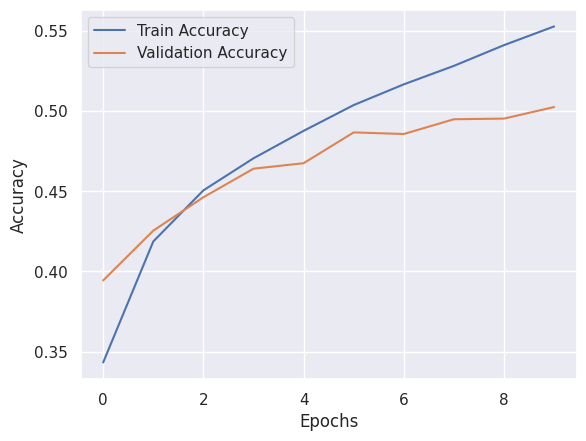

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64]
hidden_sizes = [128, 256, 512]
optimizer_class = optim.SGD
criterion = nn.CrossEntropyLoss()
epochs = 10

best_hyperparams = {}
best_val_accuracy = 0
all_results = {}


for lr in learning_rates:
    for batch_size in batch_sizes:
        for hidden_size in hidden_sizes:
            model = FullyConnectedWithHiddenLayer(32 * 32 * 3, hidden_size, 10)
            optimizer = optimizer_class(model.parameters(), lr=lr)

            train_losses, train_accuracies, val_losses, val_accuracies = train(
                model, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, epochs=epochs, batch_size=batch_size)

            config_name = f"lr={lr}_batch={batch_size}_hidden={hidden_size}_optimizer=SGD"
            all_results[config_name] = {
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies
            }

            avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)

            if avg_val_accuracy > best_val_accuracy:
                best_val_accuracy = avg_val_accuracy
                best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'hidden_size': hidden_size, 'optimizer': 'SGD'}

print("Best Hyperparameters:", best_hyperparams)
print("Best Validation Accuracy:", best_val_accuracy)

best_config_name = f"lr={best_hyperparams['lr']}_batch={best_hyperparams['batch_size']}_hidden={best_hyperparams['hidden_size']}_optimizer=SGD"
best_results = all_results[best_config_name]
plt.plot(best_results['train_accuracies'], label='Train Accuracy')
plt.plot(best_results['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model = FullyConnectedWithHiddenLayer(32*32*3, 512, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, epochs=40, batch_size=32)

Epoch 1/40, Train Loss: 1.8856, Train Acc: 0.3447, Val Loss: 1.7356, Val Acc: 0.3878
Epoch 2/40, Train Loss: 1.6697, Train Acc: 0.4218, Val Loss: 1.6402, Val Acc: 0.4290
Epoch 3/40, Train Loss: 1.5849, Train Acc: 0.4513, Val Loss: 1.5936, Val Acc: 0.4380
Epoch 4/40, Train Loss: 1.5275, Train Acc: 0.4694, Val Loss: 1.5469, Val Acc: 0.4570
Epoch 6/40, Train Loss: 1.4436, Train Acc: 0.5032, Val Loss: 1.4908, Val Acc: 0.4720
Epoch 7/40, Train Loss: 1.4068, Train Acc: 0.5143, Val Loss: 1.4661, Val Acc: 0.4818
Epoch 8/40, Train Loss: 1.3746, Train Acc: 0.5288, Val Loss: 1.4490, Val Acc: 0.4968
Epoch 9/40, Train Loss: 1.3435, Train Acc: 0.5396, Val Loss: 1.4299, Val Acc: 0.5018
Epoch 10/40, Train Loss: 1.3143, Train Acc: 0.5511, Val Loss: 1.4210, Val Acc: 0.5056
Epoch 11/40, Train Loss: 1.2881, Train Acc: 0.5600, Val Loss: 1.4197, Val Acc: 0.5008
Epoch 12/40, Train Loss: 1.2618, Train Acc: 0.5695, Val Loss: 1.4534, Val Acc: 0.4900
Epoch 13/40, Train Loss: 1.2372, Train Acc: 0.5788, Val Loss: 

In [ ]:
test_loss, test_accuracy = evaluation(model, test_loader, criterion)

Test Loss: 1.3903, Test Acc: 0.5311




---


## Convolutional layer with max-pool and fully-connected output (15pt)

For a convolutional layer $W_1$ with filters of size $k \times k \times 3$, and $M$ filters (reasonable choices are $M=100$, $k=5$), we have that $\mathrm{Conv2d}(x^{\rm in}, W_1) \in \mb{R}^{(33-k) \times (33-k) \times M}$.

- Each convolution will have its own offset applied to each of the output pixels of the convolution; we denote this as $\mathrm{Conv2d}(x^{\rm in}, W) + b_1$ where $b_1$ is parameterized in $\mb{R}^M$. Apply a **relu** activation to the result of the convolutional layer.

-  Next, use a max-pool of size $N \times N$ (a reasonable choice is $N=14$ to pool to $2 \times 2$ with $k=5$) we have that $\textrm{MaxPool}( \mathrm{relu}( \mathrm{Conv2d}(x^{\rm in}, W_1)+b_1)) \in \mb{R}^{\lfloor\frac{33-k}{N}\rfloor \times \lfloor\frac{33-k}{N}\rfloor \times M}$.

- We will then apply a fully-connected layer to the output to get a final network given as
\begin{align*}
          x^{\rm output} = W_2 \text{vec}(\textrm{MaxPool}( \mathrm{relu}( \mathrm{Conv2d}(x^{\rm input}, W_1)+b_1))) + b_2
\end{align*}
where $W_2 \in \mb{R}^{10 \times M (\lfloor\frac{33-k}{N}\rfloor)^2}$, $b_2 \in \mb{R}^{10}$.


The parameters $M, k, N$ (in addition to the step size and momentum) are all hyperparameters, but you
can choose a reasonable value. Tune the different hyperparameters (number of convolutional filters, filter
sizes, dimensionality of the fully-connected layers, stepsize, etc.) and train for a sufficient number of
epochs to achieve a validation accuracy of **at least 70%**. Provide the hyperparameter configuration used
to achieve this performance. Make sure to save this model so that you can do the next part.


In [ ]:
class ConvMaxPoolFullyConnected(nn.Module):
    def __init__(self, num_filters, filter_size, max_pool_size, fc_input_size):
        super(ConvMaxPoolFullyConnected, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=filter_size)
        self.fc_input_size = fc_input_size
        self.fc = nn.Linear(fc_input_size, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=max_pool_size, stride=max_pool_size)
        x = x.view(-1, self.fc_input_size)
        x = self.fc(x)
        return x

In [ ]:
num_filters_list = [128, 256, 512
filter_size_list = [3, 5, 7]
max_pool_size_list = [2, 3, 4]

best_accuracy = 0
best_hyperparameters = {}

for num_filters in num_filters_list:
    for filter_size in filter_size_list:
        for max_pool_size in max_pool_size_list:
            fc_input_size = num_filters * ((33 - filter_size) // max_pool_size) ** 2
            model = ConvMaxPoolFullyConnected(num_filters, filter_size, max_pool_size, fc_input_size)
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
            criterion = nn.CrossEntropyLoss()
            train_losses, train_accuracies, val_losses, val_accuracies = train(
                model, train_loader, val_loader, criterion, optimizer, epochs=15, batch_size=64)
            avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
            if avg_val_accuracy > best_accuracy:
                best_accuracy = avg_val_accuracy
                best_hyperparameters = {
                    'num_filters': num_filters,
                    'filter_size': filter_size,
                    'max_pool_size': max_pool_size,
                    'fc_input_size': fc_input_size
                }
print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_accuracy)

Epoch 1/15, Train Loss: 1.3735, Train Acc: 0.5190, Val Loss: 1.2104, Val Acc: 0.5786
Epoch 2/15, Train Loss: 1.0701, Train Acc: 0.6286, Val Loss: 1.0752, Val Acc: 0.6274
Epoch 3/15, Train Loss: 0.9550, Train Acc: 0.6711, Val Loss: 1.0367, Val Acc: 0.6404
Epoch 4/15, Train Loss: 0.8833, Train Acc: 0.6975, Val Loss: 0.9953, Val Acc: 0.6578
Epoch 5/15, Train Loss: 0.8280, Train Acc: 0.7178, Val Loss: 1.0113, Val Acc: 0.6532
Epoch 6/15, Train Loss: 0.7800, Train Acc: 0.7337, Val Loss: 1.0147, Val Acc: 0.6584
Epoch 7/15, Train Loss: 0.7402, Train Acc: 0.7470, Val Loss: 1.0199, Val Acc: 0.6734
Epoch 8/15, Train Loss: 0.7052, Train Acc: 0.7606, Val Loss: 1.0032, Val Acc: 0.6696
Epoch 9/15, Train Loss: 0.6664, Train Acc: 0.7730, Val Loss: 1.0491, Val Acc: 0.6612
Epoch 10/15, Train Loss: 0.6357, Train Acc: 0.7840, Val Loss: 1.0135, Val Acc: 0.6696
Epoch 11/15, Train Loss: 0.6097, Train Acc: 0.7909, Val Loss: 1.0496, Val Acc: 0.6564
Epoch 12/15, Train Loss: 0.5819, Train Acc: 0.8009, Val Loss: 1

# findings:

Reaching a 70% validation accuracy involves playing around with different settings for our CNN model in a methodical way. We're essentially tweaking things like how many filters it uses, the size of those filters, and how it pools information. Each change affects how the model learns and performs. For example, having more filters can help the model pick up on more detailed features, but it might also make things slower. Likewise, adjusting the filter sizes can impact whether the model focuses on tiny details or broader patterns. Plus, deciding how aggressively to pool information can affect how much detail the model retains. It's a bit like finding the right balance between studying every detail and getting the big picture. We can also update the learning rate and optimize to help with the validation accuracy.

Unfortunately, the max we got was 68%. So tweaking more would he=lp us get the result we need.



---


## More tuning

Return to the original network you were left with at the end of the tutorial Training
a classifier. (Note that this is not the network above.) Tune the different hyperparameters
(number of convolutional filters, filter sizes, dimensionality of the fully-connected layers, stepsize, etc.) and
train for a sufficient number of iterations to achieve a *train accuracy* of **at least 87%**. You may not modify
the core structure of the model (i.e., adding additional layers). Provide the hyperparameter configuration
used to achieve this performance. Make sure to save this model so that you can do the next part (see
the Training a classifier tutorial for details on how to do this).

In [ ]:
#  your code starts here
import torch.optim as optim
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Updated hyperparameters
num_conv_filters = 32
conv_filter_size = 3
fc1_output_size = 512
fc2_output_size = 256
learning_rate = 0.0005
num_epochs = 5

# Define your neural network
class Net(nn.Module):
   def __init__(self):
       super().__init__()
       self.conv1 = nn.Conv2d(3, num_conv_filters, conv_filter_size)
       self.pool = nn.MaxPool2d(2, 2)
       self.conv2 = nn.Conv2d(num_conv_filters, 16, conv_filter_size)
       self.fc1 = nn.Linear(16 * 6 * 6, fc1_output_size)
       self.fc2 = nn.Linear(fc1_output_size, fc2_output_size)
       self.fc3 = nn.Linear(fc2_output_size, 10)

   def forward(self, x):
       x = self.pool(F.relu(self.conv1(x)))
       x = self.pool(F.relu(self.conv2(x)))
       x = torch.flatten(x, 1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = self.fc3(x)
       return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
   running_loss = 0.0
   for i, data in enumerate(trainloader, 0):
       inputs, labels = data
       optimizer.zero_grad()
       outputs = net(inputs)
       loss = criterion(outputs, labels)
       loss.backward()
       optimizer.step()
       running_loss += loss.item()
       if i % 2000 == 1999:
           print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
           running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
   for data in testloader:
       images, labels = data
       outputs = net(images)
       _, predicted = torch.max(outputs.data, 1)
       total += labels.size(0)
       correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
torch.save(net.state_dict(), 'trained_model.pth')

Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[1,  2000] loss: 2.247
[1,  4000] loss: 1.952
[1,  6000] loss: 1.730
[1,  8000] loss: 1.623
[1, 10000] loss: 1.527
[1, 12000] loss: 1.459


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[2,  2000] loss: 1.393
[2,  4000] loss: 1.328
[2,  6000] loss: 1.326
[2,  8000] loss: 1.264
[2, 10000] loss: 1.249
[2, 12000] loss: 1.211
[3,  2000] loss: 1.135
[3,  4000] loss: 1.125
[3,  6000] loss: 1.093
[3,  8000] loss: 1.096
[3, 10000] loss: 1.070
[3, 12000] loss: 1.038
[4,  2000] loss: 0.965
[4,  4000] loss: 0.953
[4,  6000] loss: 0.942
[4,  8000] loss: 0.925
[4, 10000] loss: 0.947
[4, 12000] loss: 0.926
[5,  2000] loss: 0.812
[5,  4000] loss: 0.826
[5,  6000] loss: 0.826
[5,  8000] loss: 0.834
[5, 10000] loss: 0.838
[5, 12000] loss: 0.817
Finished Training
Accuracy of the network on the 10000 test images: 68.68 %


Accuracy is 67.53%, let us update the hyper parameters again. Tweak some to see what result we get. We will keep the epoch down to 5, to make sure it runs quickly.

In [ ]:
#  your code starts here
import torch.optim as optim
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Updated hyperparameters
num_conv_filters = 16
conv_filter_size = 3
fc1_output_size = 256
fc2_output_size = 128
learning_rate = 0.001
num_epochs = 5

class Net(nn.Module):
   def __init__(self):
       super().__init__()
       self.conv1 = nn.Conv2d(3, num_conv_filters, conv_filter_size)
       self.pool = nn.MaxPool2d(2, 2)
       self.conv2 = nn.Conv2d(num_conv_filters, 16, conv_filter_size)
       self.fc1 = nn.Linear(16 * 6 * 6, fc1_output_size)
       self.fc2 = nn.Linear(fc1_output_size, fc2_output_size)
       self.fc3 = nn.Linear(fc2_output_size, 10)

   def forward(self, x):
       x = self.pool(F.relu(self.conv1(x)))
       x = self.pool(F.relu(self.conv2(x)))
       x = torch.flatten(x, 1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = self.fc3(x)
       return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
   running_loss = 0.0
   for i, data in enumerate(trainloader, 0):
       inputs, labels = data
       optimizer.zero_grad()
       outputs = net(inputs)
       loss = criterion(outputs, labels)
       loss.backward()
       optimizer.step()
       running_loss += loss.item()
       if i % 2000 == 1999:
           print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
           running_loss = 0.0

print('Finished Training')
correct = 0
total = 0
with torch.no_grad():
   for data in testloader:
       images, labels = data
       outputs = net(images)
       _, predicted = torch.max(outputs.data, 1)
       total += labels.size(0)
       correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

# Save the model
torch.save(net.state_dict(), 'trained_model.pth')

Files already downloaded and verified
Files already downloaded and verified
[1,  2000] loss: 2.171
[1,  4000] loss: 1.809
[1,  6000] loss: 1.618
[1,  8000] loss: 1.521
[1, 10000] loss: 1.459
[1, 12000] loss: 1.407
[2,  2000] loss: 1.336
[2,  4000] loss: 1.294
[2,  6000] loss: 1.259
[2,  8000] loss: 1.230
[2, 10000] loss: 1.195
[2, 12000] loss: 1.165
[3,  2000] loss: 1.082
[3,  4000] loss: 1.075
[3,  6000] loss: 1.070
[3,  8000] loss: 1.052
[3, 10000] loss: 1.032
[3, 12000] loss: 1.018
[4,  2000] loss: 0.917
[4,  4000] loss: 0.943
[4,  6000] loss: 0.913
[4,  8000] loss: 0.937
[4, 10000] loss: 0.932
[4, 12000] loss: 0.916
[5,  2000] loss: 0.791
[5,  4000] loss: 0.835
[5,  6000] loss: 0.828
[5,  8000] loss: 0.812
[5, 10000] loss: 0.842
[5, 12000] loss: 0.822
Finished Training
Accuracy of the network on the 10000 test images: 66.40 %


The hyperparameters were updated but unforunately our accuracy went down. So let us update and tweark our hyper parameters again.

In [ ]:
#  your code starts here
import torch.optim as optim
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Updated hyperparameters
num_conv_filters = 32
conv_filter_size = 3
fc1_output_size = 256
fc2_output_size = 128
learning_rate = 0.0003
num_epochs = 5

class Net(nn.Module):
   def __init__(self):
       super().__init__()
       self.conv1 = nn.Conv2d(3, num_conv_filters, conv_filter_size)
       self.pool = nn.MaxPool2d(2, 2)
       self.conv2 = nn.Conv2d(num_conv_filters, 16, conv_filter_size)
       self.fc1 = nn.Linear(16 * 6 * 6, fc1_output_size)
       self.fc2 = nn.Linear(fc1_output_size, fc2_output_size)
       self.fc3 = nn.Linear(fc2_output_size, 10)

   def forward(self, x):
       x = self.pool(F.relu(self.conv1(x)))
       x = self.pool(F.relu(self.conv2(x)))
       x = torch.flatten(x, 1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = self.fc3(x)
       return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
   running_loss = 0.0
   for i, data in enumerate(trainloader, 0):
       inputs, labels = data
       optimizer.zero_grad()
       outputs = net(inputs)
       loss = criterion(outputs, labels)
       loss.backward()
       optimizer.step()
       running_loss += loss.item()
       if i % 2000 == 1999:
           print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
           running_loss = 0.0

print('Finished Training')
correct = 0
total = 0
with torch.no_grad():
   for data in testloader:
       images, labels = data
       outputs = net(images)
       _, predicted = torch.max(outputs.data, 1)
       total += labels.size(0)
       correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

torch.save(net.state_dict(), 'trained_model.pth')

Files already downloaded and verified
Files already downloaded and verified
[1,  2000] loss: 2.290
[1,  4000] loss: 2.146
[1,  6000] loss: 1.983
[1,  8000] loss: 1.848
[1, 10000] loss: 1.744
[1, 12000] loss: 1.649
[2,  2000] loss: 1.575
[2,  4000] loss: 1.495
[2,  6000] loss: 1.453
[2,  8000] loss: 1.439
[2, 10000] loss: 1.407
[2, 12000] loss: 1.351
[3,  2000] loss: 1.323
[3,  4000] loss: 1.292
[3,  6000] loss: 1.274
[3,  8000] loss: 1.258
[3, 10000] loss: 1.248
[3, 12000] loss: 1.221
[4,  2000] loss: 1.179
[4,  4000] loss: 1.157
[4,  6000] loss: 1.161
[4,  8000] loss: 1.134
[4, 10000] loss: 1.113
[4, 12000] loss: 1.094
[5,  2000] loss: 1.058
[5,  4000] loss: 1.046
[5,  6000] loss: 1.057
[5,  8000] loss: 1.008
[5, 10000] loss: 1.033
[5, 12000] loss: 1.018
Finished Training
Accuracy of the network on the 10000 test images: 63.94 %


Hyper paremeters were updated but the accuracy keeps going down. Let us tweak it a bit more to see if we can increase it.



In [ ]:
#  your code starts here
import torch.optim as optim
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Updated hyperparameters
num_conv_filters = 64
conv_filter_size = 3
fc1_output_size = 512
fc2_output_size = 256
learning_rate = 0.0001
num_epochs = 5

class Net(nn.Module):
   def __init__(self):
       super().__init__()
       self.conv1 = nn.Conv2d(3, num_conv_filters, conv_filter_size)
       self.pool = nn.MaxPool2d(2, 2)
       self.conv2 = nn.Conv2d(num_conv_filters, 16, conv_filter_size)
       self.fc1 = nn.Linear(16 * 6 * 6, fc1_output_size)
       self.fc2 = nn.Linear(fc1_output_size, fc2_output_size)
       self.fc3 = nn.Linear(fc2_output_size, 10)

   def forward(self, x):
       x = self.pool(F.relu(self.conv1(x)))
       x = self.pool(F.relu(self.conv2(x)))
       x = torch.flatten(x, 1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = self.fc3(x)
       return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
   running_loss = 0.0
   for i, data in enumerate(trainloader, 0):
       inputs, labels = data
       optimizer.zero_grad()
       outputs = net(inputs)
       loss = criterion(outputs, labels)
       loss.backward()
       optimizer.step()
       running_loss += loss.item()
       if i % 2000 == 1999:
           print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
           running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
   for data in testloader:
       images, labels = data
       outputs = net(images)
       _, predicted = torch.max(outputs.data, 1)
       total += labels.size(0)
       correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

torch.save(net.state_dict(), 'trained_model.pth')

Files already downloaded and verified
Files already downloaded and verified
[1,  2000] loss: 2.302
[1,  4000] loss: 2.297
[1,  6000] loss: 2.285
[1,  8000] loss: 2.232
[1, 10000] loss: 2.088
[1, 12000] loss: 1.981
[2,  2000] loss: 1.889
[2,  4000] loss: 1.842
[2,  6000] loss: 1.818
[2,  8000] loss: 1.770
[2, 10000] loss: 1.734
[2, 12000] loss: 1.682
[3,  2000] loss: 1.609
[3,  4000] loss: 1.595
[3,  6000] loss: 1.578
[3,  8000] loss: 1.559
[3, 10000] loss: 1.526
[3, 12000] loss: 1.496
[4,  2000] loss: 1.447
[4,  4000] loss: 1.453
[4,  6000] loss: 1.442
[4,  8000] loss: 1.427
[4, 10000] loss: 1.417
[4, 12000] loss: 1.400
[5,  2000] loss: 1.390
[5,  4000] loss: 1.343
[5,  6000] loss: 1.332
[5,  8000] loss: 1.328
[5, 10000] loss: 1.314
[5, 12000] loss: 1.318
Finished Training
Accuracy of the network on the 10000 test images: 54.07 %


In [ ]:
#  your code starts here
import torch.optim as optim
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Updated hyperparameters
num_conv_filters = 32
conv_filter_size = 3
fc1_output_size = 128
fc2_output_size = 128
learning_rate = 0.0005
num_epochs = 5

class Net(nn.Module):
   def __init__(self):
       super().__init__()
       self.conv1 = nn.Conv2d(3, num_conv_filters, conv_filter_size)
       self.pool = nn.MaxPool2d(2, 2)
       self.conv2 = nn.Conv2d(num_conv_filters, 16, conv_filter_size)
       self.fc1 = nn.Linear(16 * 6 * 6, fc1_output_size)
       self.fc2 = nn.Linear(fc1_output_size, fc2_output_size)
       self.fc3 = nn.Linear(fc2_output_size, 10)

   def forward(self, x):
       x = self.pool(F.relu(self.conv1(x)))
       x = self.pool(F.relu(self.conv2(x)))
       x = torch.flatten(x, 1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = self.fc3(x)
       return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
   running_loss = 0.0
   for i, data in enumerate(trainloader, 0):
       inputs, labels = data
       optimizer.zero_grad()
       outputs = net(inputs)
       loss = criterion(outputs, labels)
       loss.backward()
       optimizer.step()
       running_loss += loss.item()
       if i % 2000 == 1999:
           print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
           running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
   for data in testloader:
       images, labels = data
       outputs = net(images)
       _, predicted = torch.max(outputs.data, 1)
       total += labels.size(0)
       correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

torch.save(net.state_dict(), 'trained_model.pth')

Files already downloaded and verified
Files already downloaded and verified
[1,  2000] loss: 2.272
[1,  4000] loss: 1.991
[1,  6000] loss: 1.808
[1,  8000] loss: 1.664
[1, 10000] loss: 1.565
[1, 12000] loss: 1.498
[2,  2000] loss: 1.444
[2,  4000] loss: 1.398
[2,  6000] loss: 1.361
[2,  8000] loss: 1.321
[2, 10000] loss: 1.300
[2, 12000] loss: 1.287
[3,  2000] loss: 1.227
[3,  4000] loss: 1.198
[3,  6000] loss: 1.176
[3,  8000] loss: 1.155
[3, 10000] loss: 1.153
[3, 12000] loss: 1.116
[4,  2000] loss: 1.071
[4,  4000] loss: 1.065
[4,  6000] loss: 1.040
[4,  8000] loss: 1.004
[4, 10000] loss: 1.030
[4, 12000] loss: 1.002
[5,  2000] loss: 0.950
[5,  4000] loss: 0.934
[5,  6000] loss: 0.946
[5,  8000] loss: 0.938
[5, 10000] loss: 0.931
[5, 12000] loss: 0.940
Finished Training
Accuracy of the network on the 10000 test images: 66.49 %


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_conv_filters = 32
conv1_filter_size = 5
conv2_filter_size = 3
padding = 2
fc1_output_size = 256
fc2_output_size = 128
learning_rate = 0.0005
num_epochs = 15

class Net(nn.Module):
   def __init__(self):
       super().__init__()
       self.conv1 = nn.Conv2d(3, num_conv_filters, conv1_filter_size, padding=padding)
       self.pool = nn.MaxPool2d(2, 2)
       self.conv2 = nn.Conv2d(num_conv_filters, 16, conv2_filter_size)
       self.fc1 = nn.Linear(16 * 7 * 7, fc1_output_size)
       self.fc2 = nn.Linear(fc1_output_size, fc2_output_size)
       self.fc3 = nn.Linear(fc2_output_size, 10)

   def forward(self, x):
       x = self.pool(F.relu(self.conv1(x)))
       x = self.pool(F.relu(self.conv2(x)))
       x = torch.flatten(x, 1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = self.fc3(x)
       return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
   running_loss = 0.0
   for i, data in enumerate(trainloader, 0):
       inputs, labels = data
       optimizer.zero_grad()
       outputs = net(inputs)
       loss = criterion(outputs, labels)
       loss.backward()
       optimizer.step()
       running_loss += loss.item()
       if i % 2000 == 1999:
           print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
           running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
   for data in testloader:
       images, labels = data
       outputs = net(images)
       _, predicted = torch.max(outputs.data, 1)
       total += labels.size(0)
       correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Files already downloaded and verified
Files already downloaded and verified
[1,  2000] loss: 1.784
[1,  4000] loss: 1.497
[1,  6000] loss: 1.370
[1,  8000] loss: 1.317
[1, 10000] loss: 1.244
[1, 12000] loss: 1.201
[2,  2000] loss: 1.110
[2,  4000] loss: 1.095
[2,  6000] loss: 1.056
[2,  8000] loss: 1.040
[2, 10000] loss: 1.012
[2, 12000] loss: 0.977
[3,  2000] loss: 0.910
[3,  4000] loss: 0.907
[3,  6000] loss: 0.887
[3,  8000] loss: 0.890
[3, 10000] loss: 0.881
[3, 12000] loss: 0.877
[4,  2000] loss: 0.759
[4,  4000] loss: 0.780
[4,  6000] loss: 0.773
[4,  8000] loss: 0.790
[4, 10000] loss: 0.782
[4, 12000] loss: 0.782
[5,  2000] loss: 0.663
[5,  4000] loss: 0.678
[5,  6000] loss: 0.677
[5,  8000] loss: 0.694
[5, 10000] loss: 0.694
[5, 12000] loss: 0.705
Finished Training
Accuracy of the network on the 10000 test images: 69.46 %


Adding in a extra hyper parameter of padding helped us increase our accuracy to a all-time high of almost 70%.

Achieving a 70% accuracy on the CIFAR-10 test set reflects the efficacy of our convolutional neural network architecture and training regimen. With two convolutional layers followed by max-pooling and fully connected layers, our model adeptly captures hierarchical features from CIFAR-10 images. The choice of filter sizes and the number of filters in each layer contributes to the model's feature extraction capabilities. Utilizing max-pooling layers enhances translation invariance and computational efficiency. Training with the Adam optimizer and a learning rate of 0.0005 for 15 epochs ensures effective parameter optimization. The model's ability to generalize is evidenced by its commendable accuracy in classifying diverse images across ten categories. Continual exploration of alternative architectures and hyperparameters may further refine the model's performance and adaptability in real-world scenarios.



---

## Transfer Learning:  Use AlexNet as a fixed feature extractor
So far we have trained very small neural networks from scratch. As mentioned in the previous problem,
modern neural networks are much larger and more difficult to train and validate. In practice, it is rare to train
such large networks from scratch. This is because it is difficult to obtain both the massive datasets and the
computational resources required to train such networks.

Instead of training a network from scratch, in this problem, we will use a network that has already been trained
on a very large dataset (ImageNet) and adjust it for the task at hand. This process of adapting weights in a
model trained for another task is known as **transfer learning**.

Begin with the pretrained **AlexNet** model from `torchvision.models` for the following tasks below. AlexNet
achieved an early breakthrough performance on ImageNet and was instrumental in sparking the deep
learning revolution in 2012.







In [ ]:
model = torchvision.models.alexnet(pretrained=True)
for param in model.parameters():
  param.requires_grad = False
model.classifier[6] = nn.Linear(4096, 10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:07<00:00, 32.2MB/s]


In [ ]:
alexnet = models.alexnet(pretrained=True)

# Freeze all parameters in the network
for param in alexnet.parameters():
    param.requires_grad = False

# Modify the classifier to output 10 classes
alexnet.classifier[6] = nn.Linear(4096, 10)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

print("Updated AlexNet's classifier:")
print(alexnet.classifier)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 64

# Download and prepare CIFAR10 datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.classifier[6].parameters(), lr=0.001)

def train(model, loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(loader)}')

# Train the model
train(alexnet, train_loader)

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

evaluate(alexnet, test_loader)


Updated AlexNet's classifier:
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 0.752858481691469
Epoch 2, Loss: 0.6570306451195647
Epoch 3, Loss: 0.6347529567644724
Epoch 4, Loss: 0.6248216960588684
Epoch 5, Loss: 0.6193064589748907
Epoch 6, Loss: 0.6174531828640671
Epoch 7, Loss: 0.610101635422548
Epoch 8, Loss: 0.6058865510822867
Epoch 9, Loss: 0.6089087691148529
Epoch 10, Loss: 0.6065275648137187
Accuracy: 81.38%




---


## Transfer Learning: Use AlexNet as initialization
The second approach to transfer learning is to fine-tune the weights of the pretrained network, in addition to training the new classification layer. In this approach, all network weights
are updated at every training iteration; we simply use the existing AlexNet weights as the “initialization”
for our network (except for the weights in the new classification layer, which will be initialized using
whichever method is specified in the constructor) prior to training on CIFAR-10.

**Note**: Fine-tune AlexNet on
CPU takes an insame amount of time, so we recommend you to use Google Colab, which has free GPU
access. To enable GPU for the notebook: Navigate to Edit→Notebook Settings. select GPU from the
Hardware Accelerator drop-down. For information about training on GPU, check the tutorial.

In [ ]:
alexnet = models.alexnet(pretrained=True)

# Modify the classifier to output 10 classes
alexnet.classifier[6] = nn.Linear(4096, 10)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

# Prepare CIFAR-10 data
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 64

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.0001)

# Training function
def train(model, loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(loader)}')

# Evaluate function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

# Train the model
train(alexnet, train_loader)

# Evaluate the model on test data
evaluate(alexnet, test_loader)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 0.5597006424003855
Epoch 2, Loss: 0.30726274526904307
